In [1]:
import collections
import glob
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import random
from collections import defaultdict

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from utils_parallel_syn_gradient import *

all_N = [10, 20, 50, 100, 200, 500, 800, 1000, 2000, 5000]
colors = plt.cm.tab10.colors
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})/

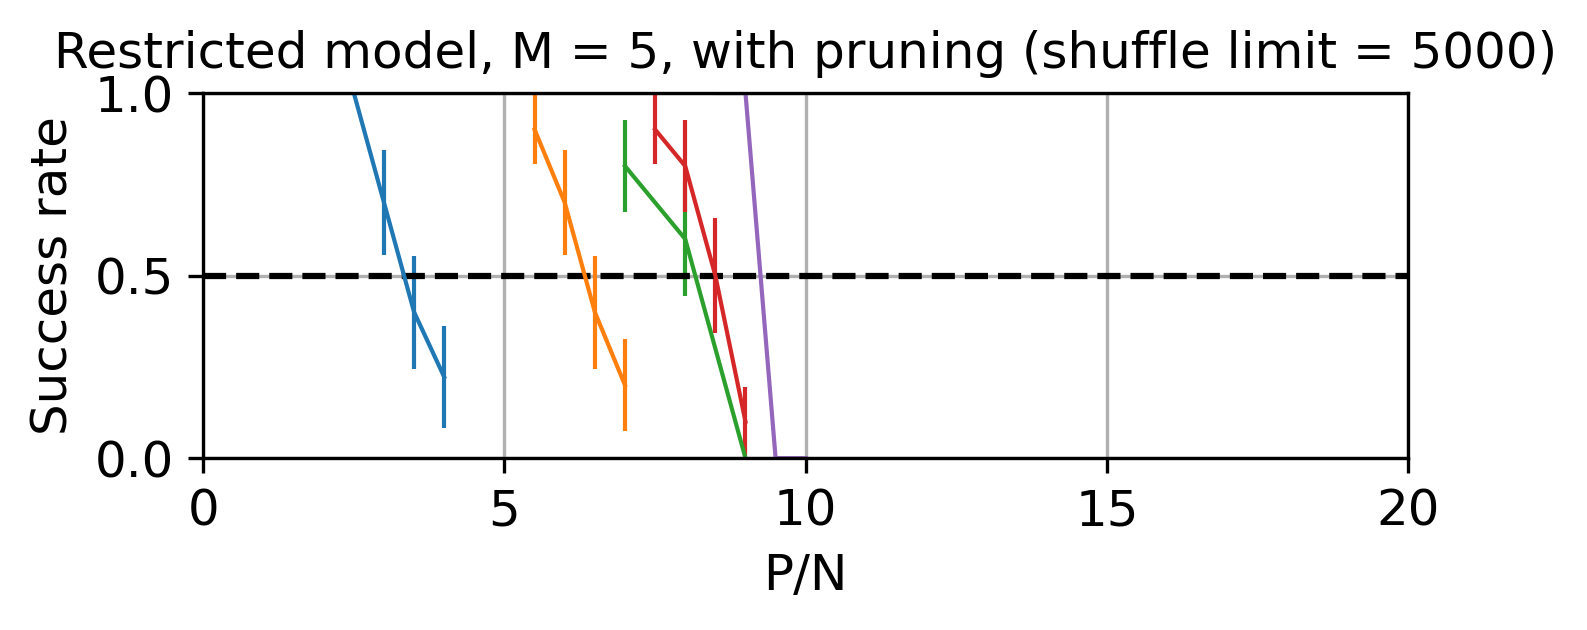

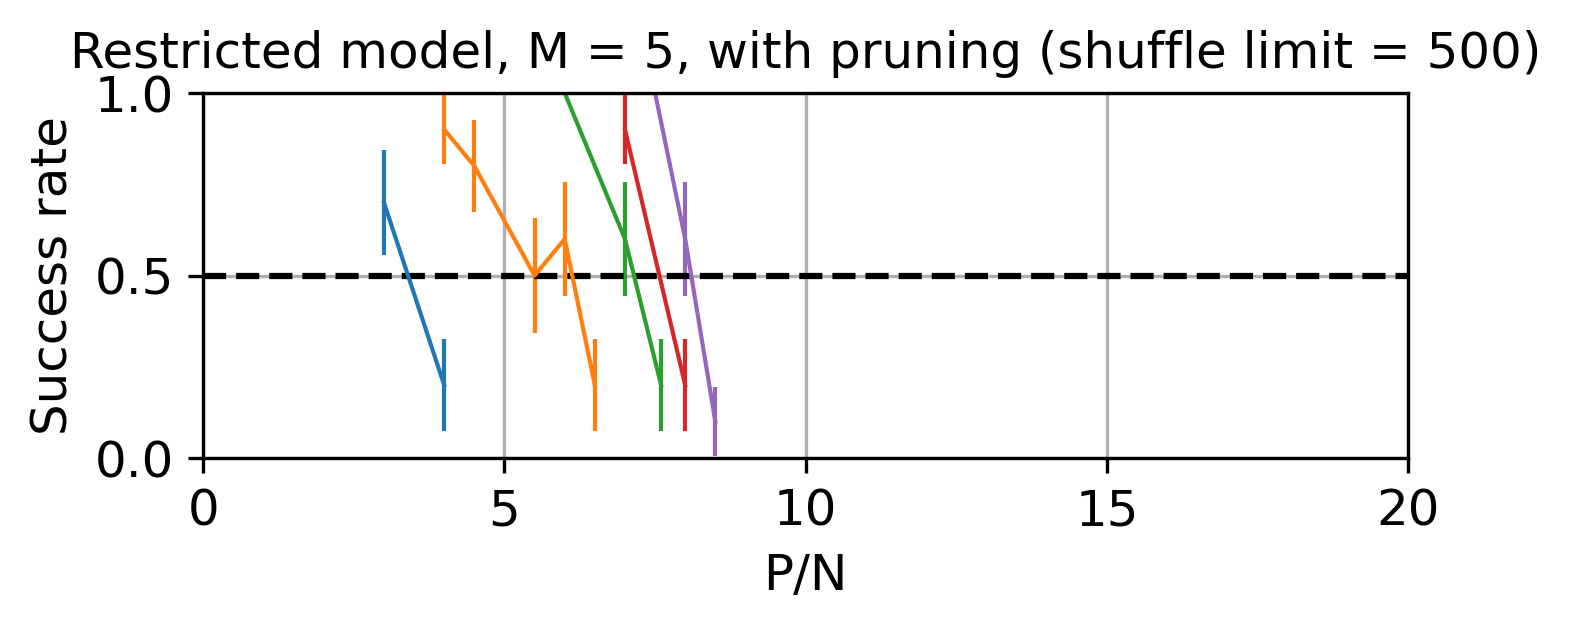

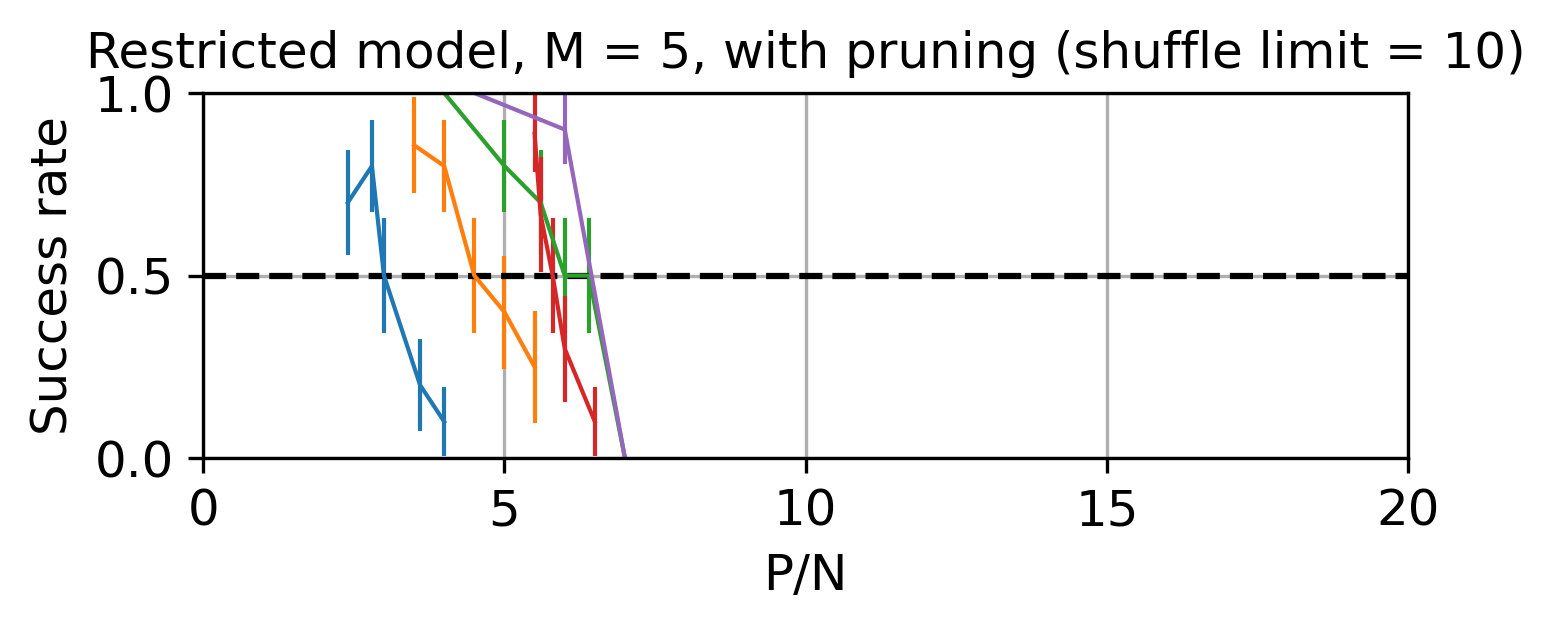

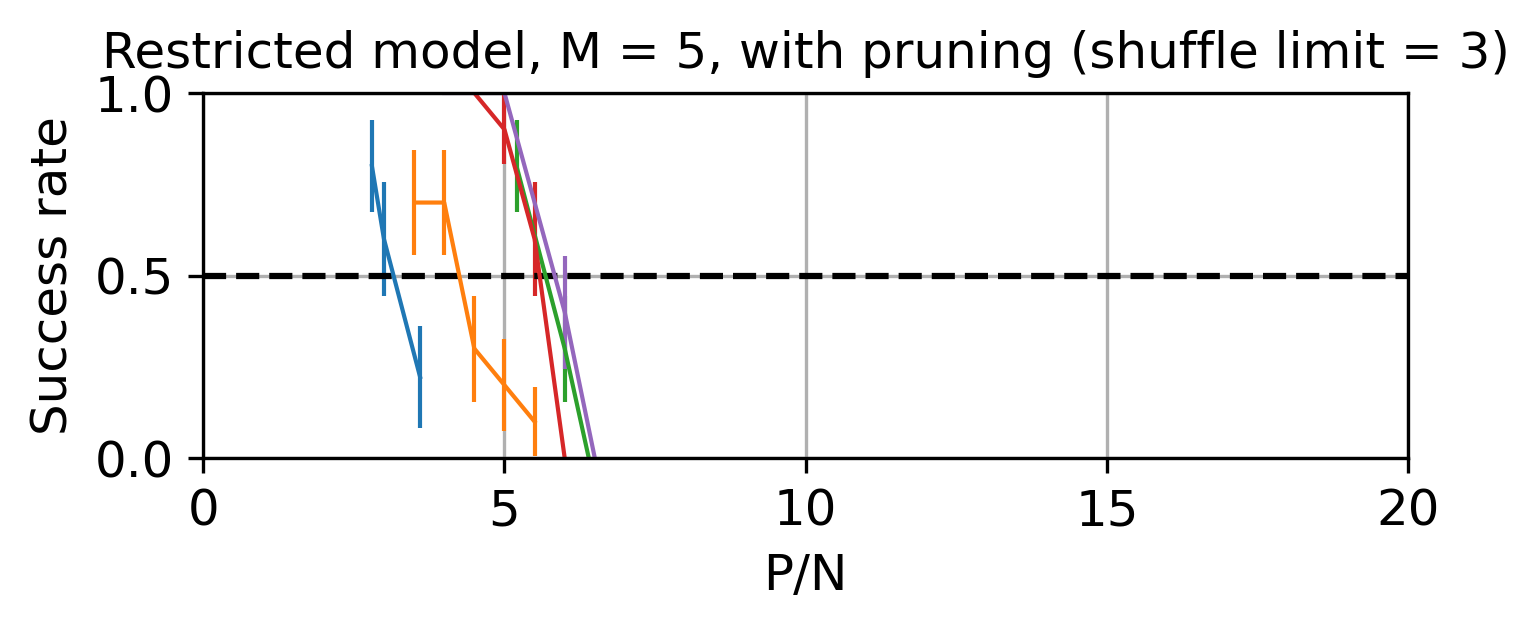

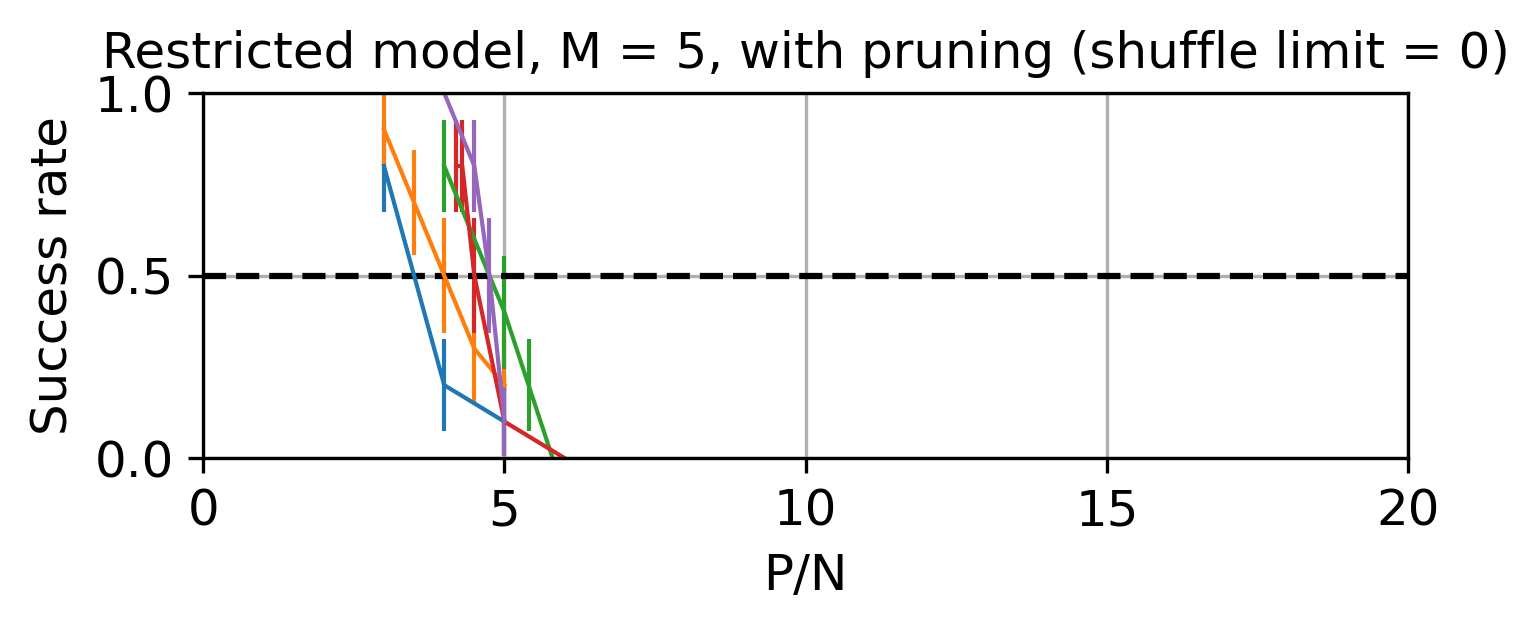

In [2]:
all_count_trial_dict = defaultdict(dict)
all_capacity_dict = defaultdict(dict)
for shuffle_limit in [5000, 500, 10, 3, 0]:
    experi = {}
    allN = set()
    allM = set()

    for N in [10, 20, 50, 100, 200, 500]:
        if shuffle_limit == 0:
            path = glob.glob(
                "./N_" + str(N) + "_png/*seed_[0-9]*_shuffle_False" + ".png"
            ) + glob.glob(
                "./N_" + str(N) + "_png/*seed_[0-9]*_shuffle_False" + "_true.png"
            )
        else:
            path = glob.glob(
                "./N_"
                + str(N)
                + "_png/*seed_[0-9]*_shuffle_True_shuffle_limit_"
                + str(shuffle_limit)
                + ".png"
            ) + glob.glob(
                "./N_"
                + str(N)
                + "_png/*seed_[0-9]*_shuffle_True_shuffle_limit_"
                + str(shuffle_limit)
                + "_true.png"
            )

        for p_ in path:
            params = p_.split("/")[-1].replace(".png", "").split("_")

            N_, M_, P_, seed_ = (
                int(params[1]),
                int(params[3]),
                int(params[5]),
                int(params[7]),
            )
            if M_ not in [5]:
                continue
            if (N_, M_) not in experi:
                experi[(N_, M_)] = {}
            if P_ not in experi[(N_, M_)]:
                experi[(N_, M_)][P_] = np.ones((20,), dtype=int) * np.nan

            if experi[(N_, M_)][P_][seed_] > 0:
                continue
            else:
                experi[(N_, M_)][P_][seed_] = int(params[-1] == "true")

            if N_ not in allN:
                allN.add(N_)
            if M_ not in allM:
                allM.add(M_)

        for N_, M_ in experi:
            for P_ in experi[(N_, M_)]:
                experi[(N_, M_)][P_] = experi[(N_, M_)][P_][
                    ~np.isnan(experi[(N_, M_)][P_])
                ]
            experi[(N_, M_)] = collections.OrderedDict(sorted(experi[(N_, M_)].items()))

    arrayN = np.array(sorted(list(allN)))
    arrayM = np.array(sorted(list(allM)))
    countTrialDict = {}
    for N in arrayN:
        for M in arrayM:
            if (N, M) in experi:
                countTrial = []
                for k in experi[(N, M)]:
                    countTrial.append(
                        (
                            k,
                            k / N,
                            len(experi[(N, M)][k]),
                            sum(experi[(N, M)][k]) / len(experi[(N, M)][k]),
                        )
                    )
                countTrialDict[(N, M)] = countTrial
            else:
                countTrialDict[(N, M)] = []

    for N, M in countTrialDict:
        if M != 10:
            continue
        print("N, M:", N, M, " P, alpha, count, rate: ")
        print(countTrialDict[(N, M)])
        print("----")
    all_count_trial_dict[shuffle_limit] = countTrialDict
    plt.figure(figsize=(5, 2.2), dpi=300)
    # plt.plot([3, 14], [0.5, 0.5], "k--")
    c = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
    ]

    arrayN = np.array(sorted(list(allN)))
    arrayM = np.array(sorted(list(allM)))
    capacity = {}
    sample_repeat = 100
    sample_ratio = 0.5
    for count, (N, M) in enumerate(experi):
        if M not in [3, 5, 10]:
            continue
        if M not in capacity:
            capacity[M] = []

        psedoC = []
        for i in range(sample_repeat):
            psedoX = []
            psedoY = []

            for P in experi[(N, M)]:
                psedoX += [P / N] * int(len(experi[(N, M)][P]) * sample_ratio)
                psedoY += random.sample(
                    list(experi[(N, M)][P]),
                    k=int(len(experi[(N, M)][P]) * sample_ratio),
                )
            if min(psedoY) == max(psedoY):
                continue
            clf = LogisticRegression(penalty="none").fit(
                np.array(psedoX).reshape(-1, 1), np.array(psedoY)
            )
            newX = np.linspace(
                min(experi[(N, M)].keys()) / N, max(experi[(N, M)].keys()) / N, 20
            )
            if np.abs(-clf.intercept_[0] / clf.coef_[0][0]) > 20:
                continue
            psedoC.append(-clf.intercept_[0] / clf.coef_[0][0])

            probs = clf.predict_proba(newX.reshape(-1, 1))

            plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
            # plt.plot(
            #     newX,
            #     probs[:, 1],
            #     alpha=0.15,
            #     linewidth=0.5,
            #     color=c[np.where(arrayN == N)[0][0]],
            # )

        capacity[M].append(
            [N, M, np.nanmean(np.array(psedoC)), np.nanstd(np.array(psedoC))]
        )

        plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
        plt.errorbar(
            np.array(list(experi[(N, M)].keys())) / N,
            [np.mean(np.array(experi[(N, M)][P])) for P in experi[(N, M)]],
            yerr=[
                np.std(np.array(experi[(N, M)][P])) / np.sqrt(len(experi[(N, M)][P]))
                for P in experi[(N, M)]
            ],
            label="N=" + str(N),
            linewidth=1,
            color=colors[all_N.index(N)],
        )

        # plt.errorbar(
        #     [np.array(psedoC).mean()],
        #     [0.5],
        #     xerr=np.array(psedoC).std(),
        #     fmt="o",
        #     linewidth=2,
        #     capsize=2,
        #     color=c[np.where(arrayN == N)[0][0]],
        # )
    for i in range(arrayM.size):
        plt.subplot(arrayM.size, 1, i + 1)
        plt.title(
            "Restricted model, M = "
            + str(arrayM[i])
            + ", with pruning (shuffle limit = "
            + str(shuffle_limit)
            + ")",
            fontsize=12,
        )
        # plt.legend()
        plt.xlim([0, 20])
        plt.ylim([0, 1])
        plt.plot([0, 20], [0.5, 0.5], "k--")
        plt.xticks([0, 5, 10, 15, 20], fontsize=12)
        plt.yticks([0, 0.5, 1], fontsize=12)
        plt.grid()
        plt.xlabel("P/N", fontsize=12)
        plt.ylabel("Success rate", fontsize=12)
    for M in capacity:
        capacity[M] = np.array(capacity[M])
    capacity = collections.OrderedDict(sorted(capacity.items()))

    plt.tight_layout()

    plt.savefig("success_rate_limited_shuffle_" + str(shuffle_limit) + ".pdf")
    plt.show()

    all_capacity_dict[shuffle_limit] = capacity


# plot final result

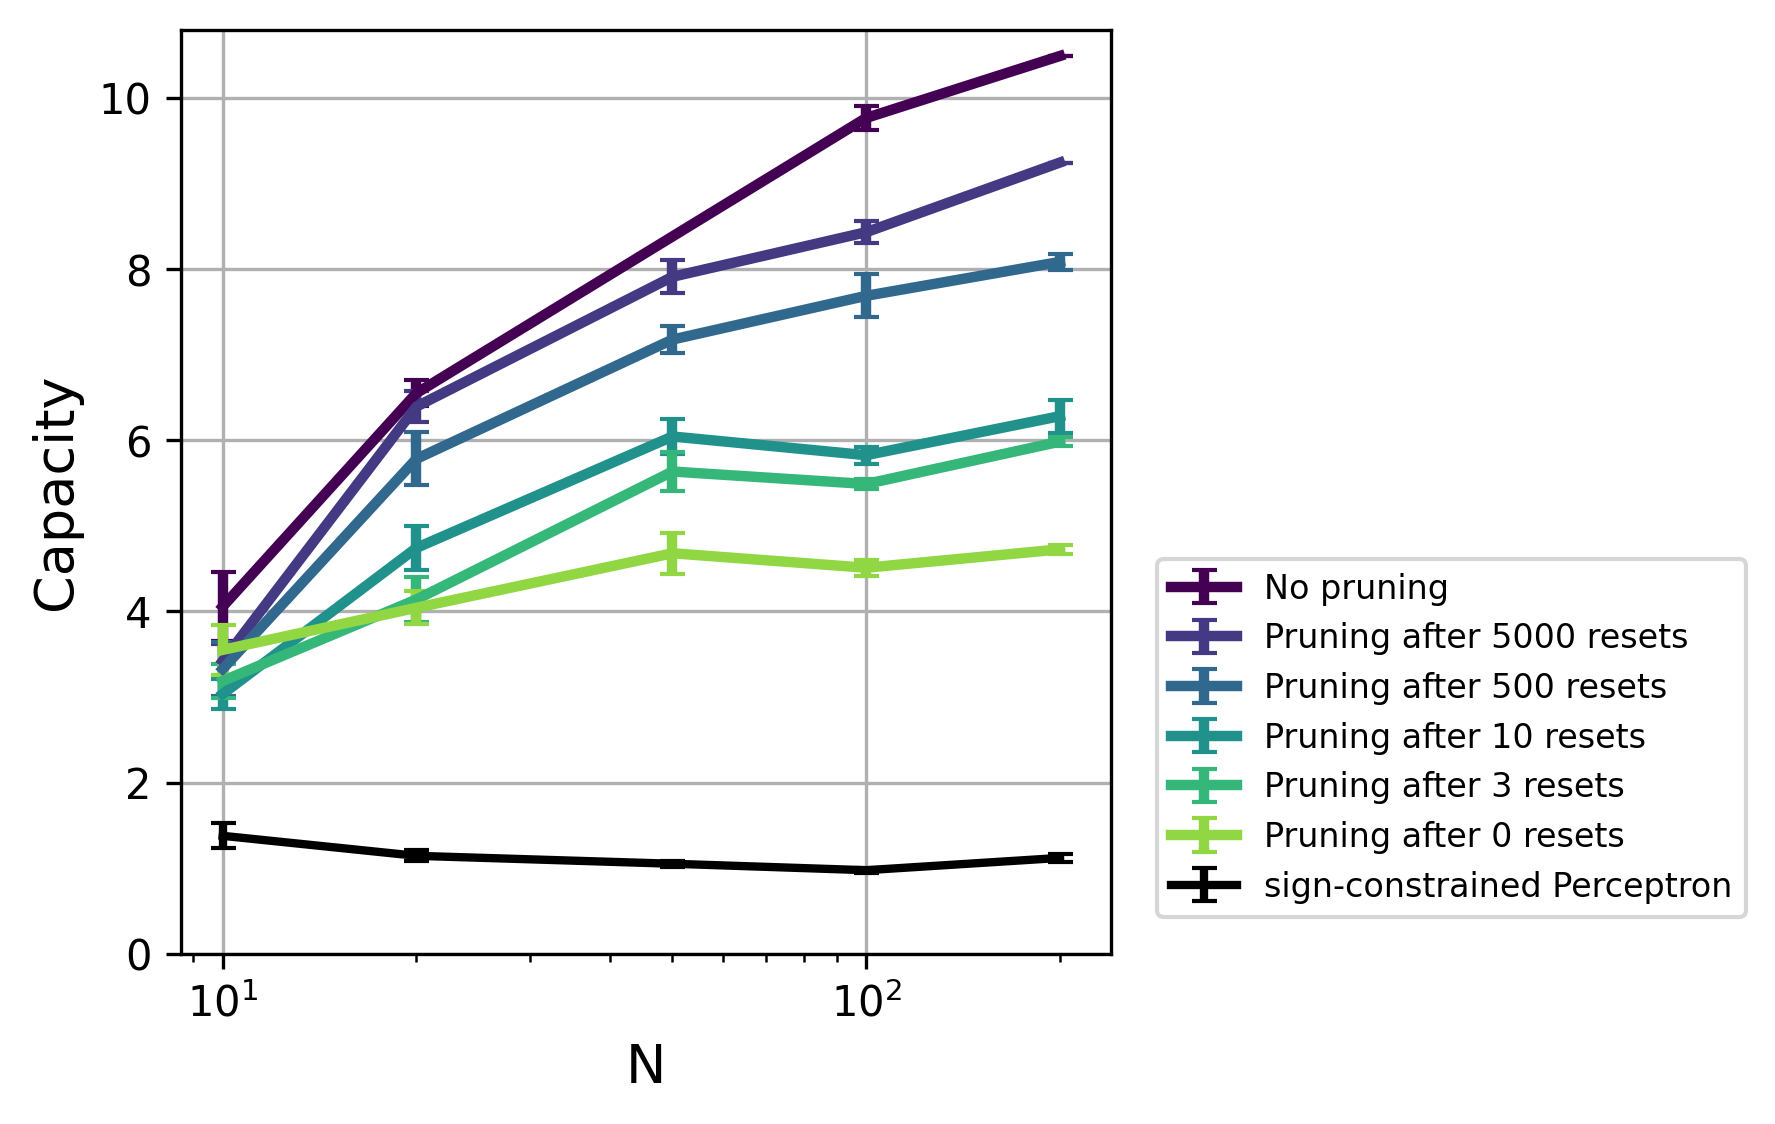

In [18]:
ax = plt.figure(figsize=(4, 4), dpi=300)
# color = plt.cm.get_cmap("Paired").colors
# color = [
#     "tab:blue",
#     "tab:orange",
#     "tab:green",
#     "tab:red",
#     "tab:purple",
#     "tab:brown",
#     "tab:pink",
# ]
color = plt.cm.viridis(np.linspace(0, 1, 7))


# load capacity from normal parallel synapse model
with open("capacity_restricted_model.pkl", "rb") as f:
    capacity_no_limit = pickle.load(f)
capacity_no_limit = capacity_no_limit[5]
plt.errorbar(
    capacity_no_limit[:-3, 0],
    capacity_no_limit[:-3, 2],
    yerr=capacity_no_limit[:-3, 3],
    capsize=3,
    color=color[0],
    linewidth=2.5,
    label="No pruning",
)

for i_repeat, k in enumerate(all_capacity_dict):
    capacity = all_capacity_dict[k]
    for i, M in enumerate(capacity):
        x, y, yerr = capacity[M][:, 0], capacity[M][:, 2], capacity[M][:, 3]
        plt.errorbar(
            x[~np.isnan(y)],
            y[~np.isnan(y)],
            yerr=yerr[~np.isnan(y)],
            capsize=3,
            color=color[i_repeat + 1],
            label="Pruning after " + str(k) + " resets",
            linewidth=2.5,
            alpha=1,
        )

distribution = "uniform"
learning_rule = "amit"
with open(
    "perceptron_sign_constrained_capacity_{}_{}.pkl".format(
        distribution, learning_rule
    ),
    "rb",
) as f:
    capacity_perceptron_sign_constrained = pickle.load(f)
capacity_perceptron_sign_constrained = np.array(capacity_perceptron_sign_constrained)

# capacity_no_limit = capacity_no_limit[5]
plt.errorbar(
    capacity_perceptron_sign_constrained[:-2, 0],
    capacity_perceptron_sign_constrained[:-2, 1],
    yerr=capacity_perceptron_sign_constrained[:-2, 2],
    capsize=3,
    linewidth=2,
    color="k",
    label="sign-constrained Perceptron",
)
plt.xscale("log")
# plt.yscale('log')
# plt.xticks([0 + i*100 for i in range(12)])
plt.grid()

plt.xlabel("N", fontsize=13)
plt.ylabel("Capacity", fontsize=13)
plt.ylim([0, 10.8])

plt.xlim([-5, 0.24e3])
plt.legend(ncol=1, prop={"size": 8}, loc=[1.05, 0.04])
# plt.grid()
# plt.title("train with noise, test on training data")
# plt.tight_layout()


plt.savefig("capacity_limited_shuffle.pdf")

# plot activation histogram

In [ ]:
from parallel_synapse_gradient import *


class args:
    def init(self):
        N = 0
        M = 0
        seed = 0
        P = 0


args.N, args.M, args.seed, args.P = 50, 5, 0, 450
allActv = []
# for args.seed in range(10):
model_params = {
    "N": args.N,  # input dimension
    "M": args.M,  # parallel synapse number
    "seed": args.seed,
    "device": torch.device("cpu"),
}
train_params = {
    "margin": 0.1,  # only applied when 'loss' is hinge
    "threslr": 1e-6,
    "adamlr": 0.003,
    "minAmpli": 1e-1,
    "Nepoch": 160000,
    "P": args.P,
    "maxRecord": 4000,
    "downSample": 100,
    "NthresPool": int(args.P / 2),
}
shuffle_limit = 3
path = ""
folder = "./N_" + str(model_params["N"])
# folder = './monsyn4'
#
path += (
    "N_"
    + str(model_params["N"])
    + "_M_"
    + str(model_params["M"])
    + "_P_"
    + str(train_params["P"])
    + "_seed_"
    + str(model_params["seed"])
    + "_shuffle_True_shuffle_limit_"
    + str(shuffle_limit)
)

model = ParallelSyn(model_params)


state_dict = torch.load(folder + "/" + path, map_location=model_params["device"])
model.load_state_dict(state_dict)


In [166]:
def plot_activation(model, n, file):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]

    nX = 100
    """
    plot the staircase functions
    """
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim)
    )

    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()

    x = x[:, 0]
    x = x.numpy()
    plt.rcParams.update({"font.size": 12})
    plt.figure(figsize=(4.5, 4.5))
    plt.plot(x, actv[:, :n], linestyle="-", alpha=0.8)
    plt.xlabel("input")
    plt.ylabel("arbitrary unit")
    plt.title("aggregate synaptic function")
    plt.tight_layout()
    plt.show()

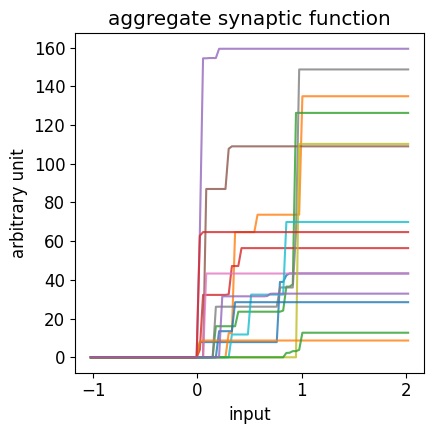

In [167]:
plot_activation(model, 15, "")


In [168]:
def ampli_hist(model):
    """
    plot the amplitude histogram of the synaptic function

    method 0:
        plot the histogram of the nonzero a**2
    method 1:
        local variation of the amplitude
    method 2:
        starting from zero, get slopes

    """

    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    # method 0
    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)
    plt.figure(figsize=(9.0, 3.0), dpi=200)
    plt.subplot(1, 3, 1)
    plt.hist(ampli.ravel(), bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    # plt.title("a_{ij}^2")
    # plt.tight_layout()
    # plt.savefig("a_squared_log_scale.pdf")
    # plt.title("amplitude histogram")

    # method 1, local variation of the amplitude
    nX = 100
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim)
    )
    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()
    x = x[:, 0]
    x = x.numpy()
    actv_local_slope = np.diff(actv, axis=0).T / np.diff(x).ravel()
    actv_local_slope = actv_local_slope[
        ~np.isnan(actv_local_slope) & (actv_local_slope > 0)
    ]
    plt.subplot(1, 3, 2)
    plt.hist(actv_local_slope, bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Local slope")
    plt.ylabel("Frequency")

    actv_global_slope = (actv[1:, :] - actv[0, :]).T / (x[1:] - x[0]).ravel()
    actv_global_slope = actv_global_slope[
        ~np.isnan(actv_global_slope) & (actv_global_slope > 0)
    ]

    plt.subplot(1, 3, 3)
    plt.hist(actv_global_slope, bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Global slope")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


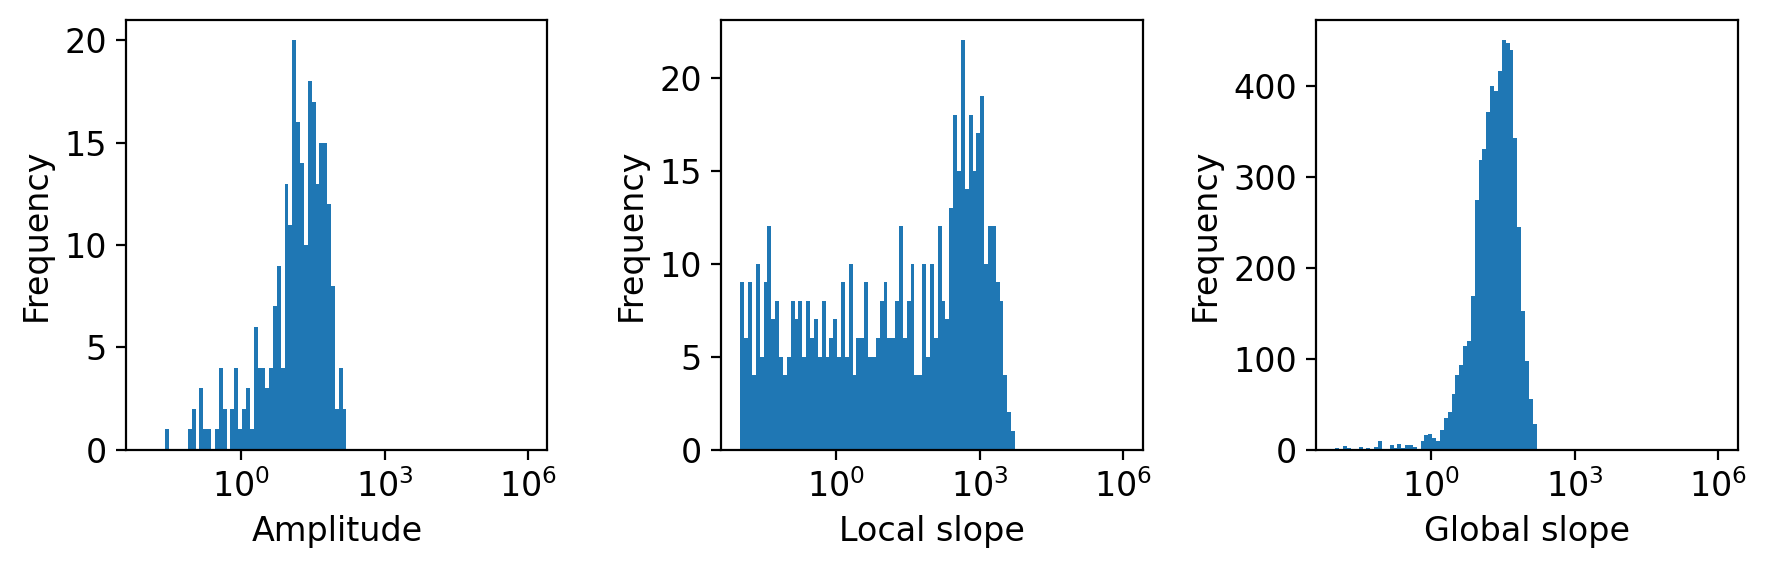

In [169]:
ampli_hist(model)

In [170]:
def thres_ampli(model):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)
    plt.figure(figsize=(9, 3.0))
    plt.subplot(1, 3, 1)
    plt.hist(ampli.ravel(), bins=100)
    plt.xlabel("amplitude")
    plt.ylabel("frequency")
    plt.title("amplitude histogram")
    plt.subplot(1, 3, 2)
    plt.hist(thres.ravel(), bins=50)
    plt.xlabel("threshold")
    plt.ylabel("frequency")
    plt.title("threshold histogram")

    plt.subplot(1, 3, 3)

    plt.errorbar(thresBin[1:], allAmpli[:, 0], yerr=allAmpli[:, 1])
    plt.xlabel("threshold")
    plt.ylabel("amplitude ")
    plt.title("amplitude vs threshold")
    plt.tight_layout()
    plt.show()

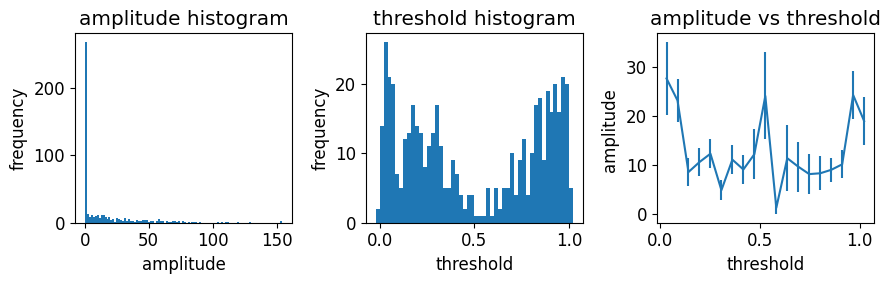

In [171]:
thres_ampli(model)

In [172]:
from collections import Counter


def plot_synapse_count(model_dict):
    plt.figure(figsize=(5, 4.5), dpi=300)
    # Plot bars for each model
    bar_width = 0.2
    for i, (model_name, model) in enumerate(model_dict.items()):
        synapse_count = (model.ampli > 0).sum(axis=1).numpy()
        counts = Counter(synapse_count)
        x = np.array(list(counts.keys()))
        plt.bar(x + i * bar_width, list(counts.values()), bar_width, label=model_name)

    plt.xlabel("Number of parallel synapses per connection")
    plt.ylabel("Frequency")
    # plt.title("synapse count histogram")
    plt.legend()
    plt.xticks(x + bar_width / 2, x)
    plt.tight_layout()
    plt.savefig("synapse_count_histogram.pdf")
    plt.show()


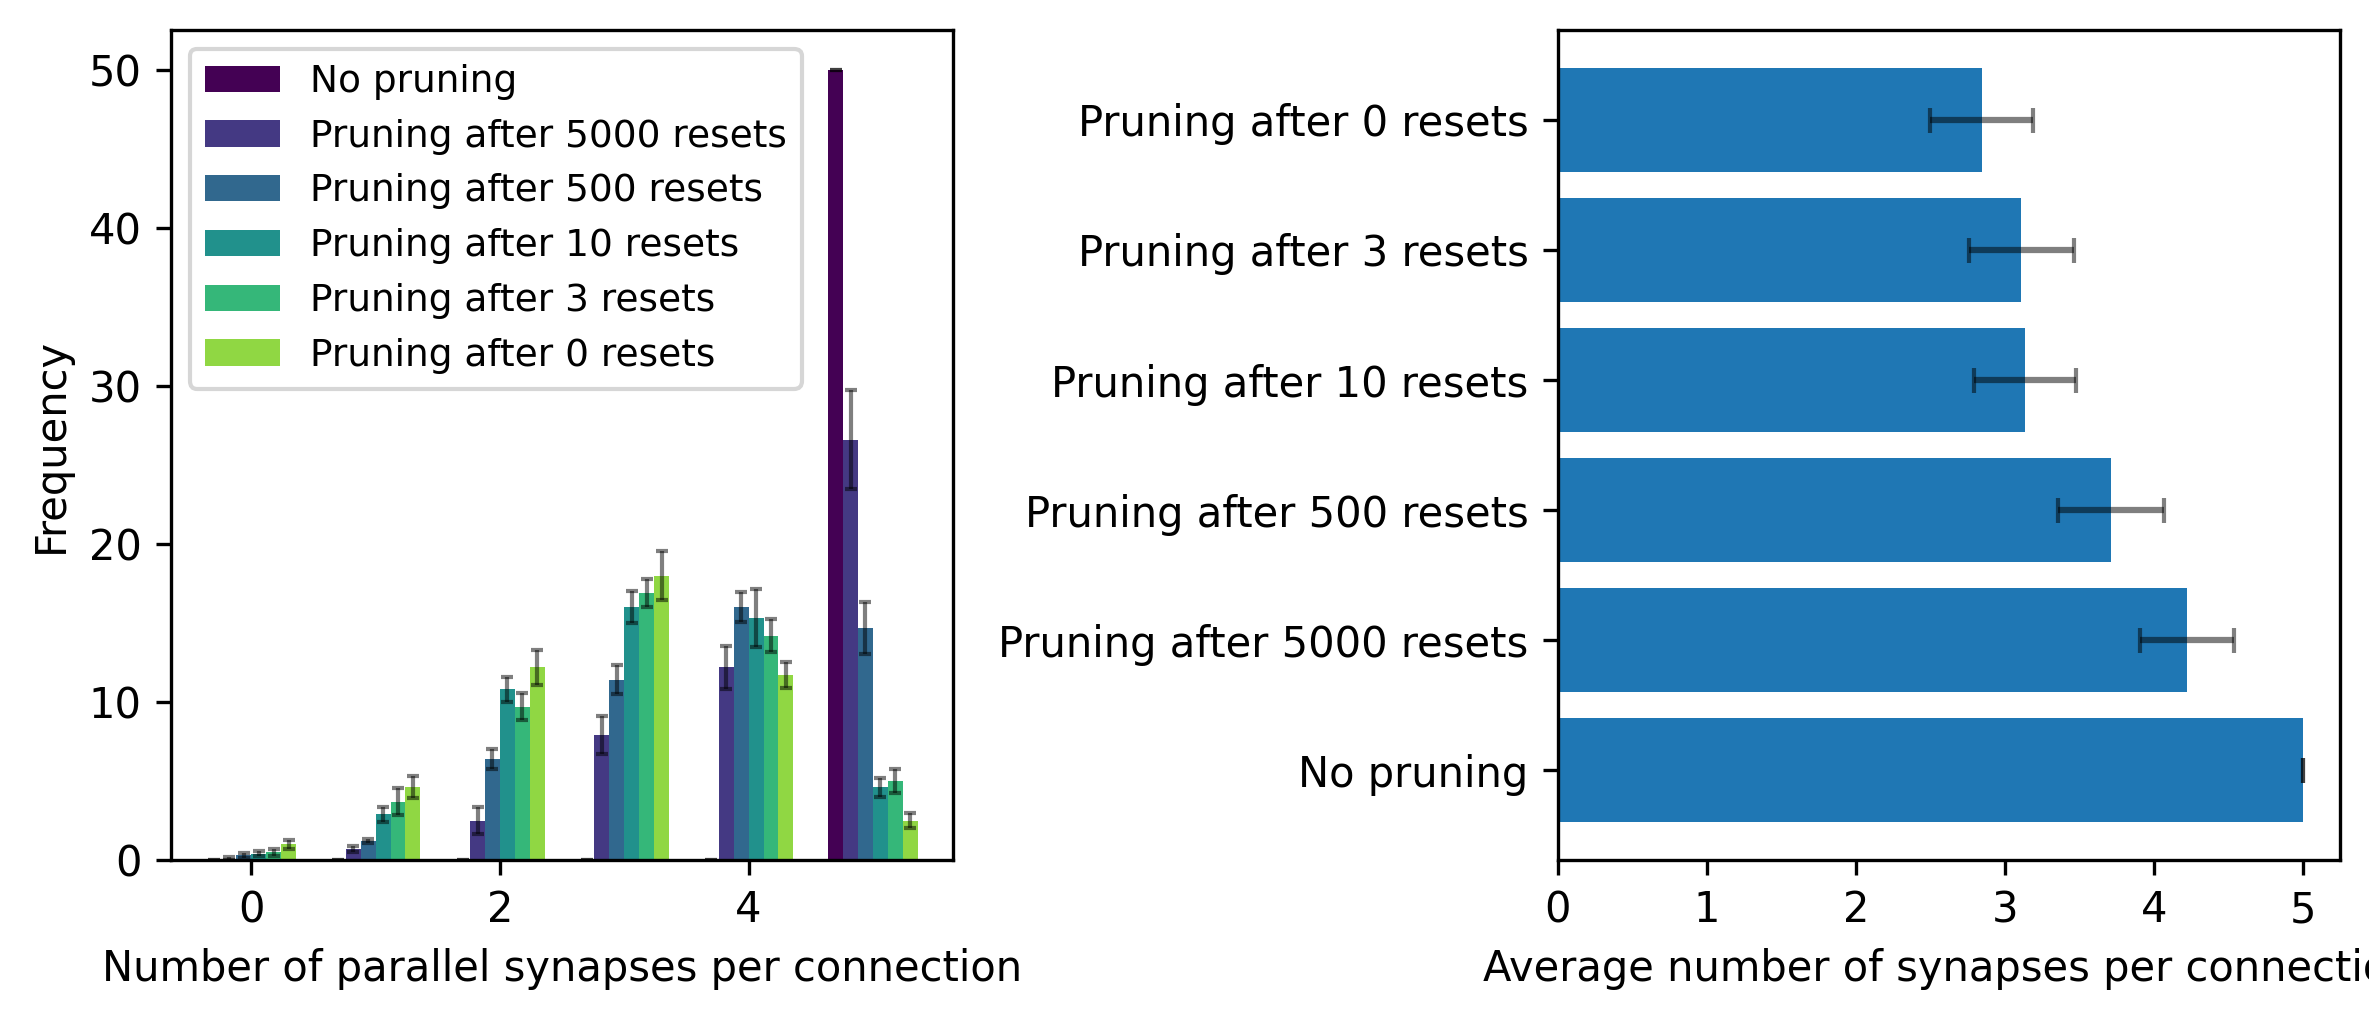

In [17]:
path_dict = {
    "No pruning": [f"./N_50/N_50_M_5_P_350_seed_{seed}" for seed in range(10)],
    "Pruning after 5000 resets": [
        f"./N_50/N_50_M_5_P_350_seed_{seed}_shuffle_True_shuffle_limit_5000"
        for seed in range(10)
    ],
    "Pruning after 500 resets": [
        f"./N_50/N_50_M_5_P_300_seed_{seed}_shuffle_True_shuffle_limit_500"
        for seed in range(10)
    ],
    "Pruning after 10 resets": [
        f"./N_50/N_50_M_5_P_300_seed_{seed}_shuffle_True_shuffle_limit_10"
        for seed in range(10)
    ],
    "Pruning after 3 resets": [
        f"./N_50/N_50_M_5_P_300_seed_{seed}_shuffle_True_shuffle_limit_3"
        for seed in range(10)
    ],
    "Pruning after 0 resets": [
        f"./N_50/N_50_M_5_P_250_seed_{seed}_shuffle_False" for seed in range(10)
    ],
}

model_dict = defaultdict(list)


# Redefine plot_synapse_count to handle mean and std
def plot_synapse_count(synapse_count_dict):
    plt.figure(figsize=(8, 3.5), dpi=300)
    bar_width = 0.12
    color = plt.cm.viridis(np.linspace(0, 1, 7))
    plt.subplot(1, 2, 1)
    for i, (model_name, counts_list) in enumerate(synapse_count_dict.items()):
        # Convert list of counts to array
        freq_counts = []
        for counts in counts_list:
            freq_ = []
            for j in range(6):
                freq_.append(np.sum(counts == j))
            freq_counts.append(freq_)
        freq_counts = np.array(freq_counts)
        mean_freq = np.mean((freq_counts), axis=0)
        std_freq = np.std((freq_counts), axis=0) / np.sqrt(len(freq_counts))
        # Calculate std for each unique count

        plt.bar(
            np.arange(6) + i * bar_width - bar_width * 2.5,
            mean_freq,
            bar_width,
            label=model_name,
            color=color[i],
        )
        plt.errorbar(
            np.arange(6) + i * bar_width - bar_width * 2.5,
            mean_freq,
            yerr=std_freq,
            capsize=1.5,
            linewidth=1,
            fmt="none",
            color="k",
            alpha=0.5,
        )

    plt.xlabel("Number of parallel synapses per connection")
    plt.ylabel("Frequency")
    plt.legend(fontsize=9)
    plt.subplot(1, 2, 2)
    # plot total number of synapses
    total_synapses = [np.mean(counts) for counts in synapse_count_dict.values()]
    total_synapses_std = [
        np.std(counts) / np.sqrt(len(counts)) for counts in synapse_count_dict.values()
    ]
    plt.barh(list(path_dict.keys()), total_synapses)
    plt.errorbar(
        total_synapses,
        list(path_dict.keys()),
        xerr=total_synapses_std,
        fmt="none",
        capsize=3,
        color="black",
        alpha=0.5,
    )
    plt.xlabel("Average number of synapses per connection")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig("synapse_count_histogram.pdf")
    plt.show()


# Load models and compute synapse counts
model_dict = defaultdict(list)
synapse_count_dict = defaultdict(list)

for k, path_list in path_dict.items():
    model_params["N"] = 50
    model_params["M"] = 5

    # Load models for different seeds
    for path in path_list:
        try:
            model = ParallelSyn(model_params)
            state_dict = torch.load(path, map_location=model_params["device"])
            model.load_state_dict(state_dict, strict=False)
            model_dict[k].append(model)

            # Compute synapse count
            synapse_count = (model.ampli > 0).sum(axis=1).numpy()
            synapse_count_dict[k].append(synapse_count)
        except:
            print(f"Error loading model {path}")

plot_synapse_count(synapse_count_dict)
